In [1]:
import pandas as pd
import numpy as np

In [3]:
from src.db import engine

In [4]:
df = pd.read_sql_table('activities', con=engine)

In [5]:
df.distance = df.distance / 1000

In [6]:
laps = pd.read_sql_table('laps', con=engine, index_col='id')

In [7]:
m = pd.merge(df, laps.groupby('activity_id').first().reset_index(), left_on='id', right_on='activity_id', how='outer')
m.set_index('start_time', inplace=True)
m.index = pd.to_datetime(m.index)

<Axes: xlabel='start_time'>

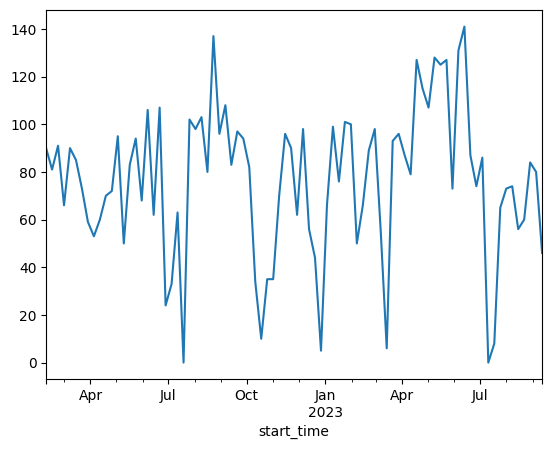

In [15]:
m.distance.groupby(pd.Grouper(freq='D')).sum().groupby(pd.Grouper(freq='7D')).sum().iloc[-12*7:].plot()

In [14]:
records = pd.read_sql_table('records', con=engine, index_col='id')

In [15]:
records['speed'] *= 3.6

/Users/julienroulle/dev/stridze-tools/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/julienroulle/dev/stridze-tools/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 25.0)

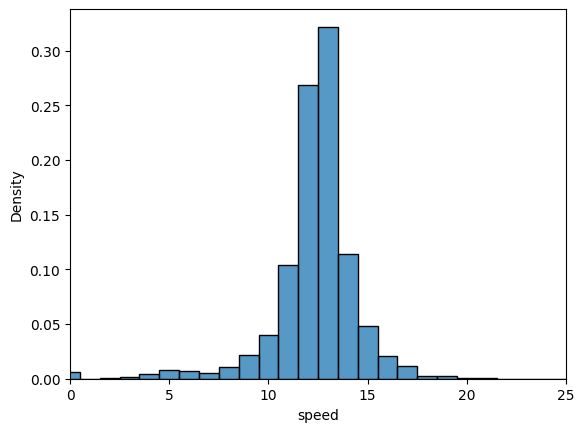

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=records, x="speed", discrete=True, binwidth=1, binrange=(0, 25), stat='density')
plt.xlim(0, 25)

In [17]:
speeds = records.groupby('speed').sum('distance')

In [18]:
speeds = speeds.drop(index=[0.0, 63.75600000000001])

In [29]:
speeds

,position_lat,position_long,distance,altitude,enhanced_altitude,enhanced_speed,heart_rate,cadence,activity_id
speed,,,,,,,,,
0.8064,364.040404,-588.931575,19303.11,244.4,244.4,1.792,972.0,358.0,44997319802
0.8388,45.534278,-73.579505,9025.85,22.0,22.0,0.233,130.0,85.0,7141942464
0.8748,137.046610,-221.308366,15364.00,405.8,405.8,0.729,391.0,210.0,16466246958
0.9072,182.098517,-294.280037,23677.01,84.0,84.0,1.008,592.0,227.0,22250479280
0.9396,185.112339,-222.815803,21018.16,32.0,32.0,1.044,505.0,227.0,21940248003
...,...,...,...,...,...,...,...,...,...
27.4104,45.509702,-73.549329,492.49,33.6,33.6,7.614,101.0,105.0,4843375738
27.6120,45.509703,-73.549240,499.40,33.6,33.6,7.670,105.0,105.0,4843375738
28.0152,45.524425,-73.564327,2317.75,39.0,39.0,7.782,158.0,98.0,4620185348
